In [1]:
import os, torch, librosa, sklearn, librosa.display, glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import Audio
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

random_state = np.random.RandomState(0)

data_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data'
genres=(list(os.listdir(f'{data_path}/genres_original/')))

# Alphabetize the list of genres
sorted_genres = sorted(genres)

# Create a dictionary with genres as keys and values from 0 to n-1
genre_dict = {genre: index for index, genre in enumerate(sorted_genres)}
print(genre_dict)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [2]:
# clear outputs in kaggle
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)

In [3]:
# Transforming audio files into Mel spectrograms and saving

print("Transforming the Audio Files into Mel Spectrograms:")
batch_size = 32

hop_length = 512
forbidden = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav'
mel_spectogram_data = {}
for genre in genre_dict.keys():
    
    mel_spectogram_data[genre] = []
    for name in glob.glob(data_path + "/genres_original/" + genre + "/*"):
        if name != forbidden:
            data,sampling_rate = librosa.load(name)
            sgram = librosa.stft(data) # Regular spectrogram
            magphase, _ = librosa.magphase(sgram)
            mel_spec = librosa.feature.melspectrogram(S=magphase, sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)



Transforming the Audio Files into Mel Spectrograms:


In [4]:
print("Saving the Mel Spectrogram Images:")
plt.ioff()           
x = []
y = []
for genre in genre_dict.keys():

   
    for i in range(len(mel_spectogram_data[genre])):
        plt.figure(figsize=(16, 6))

        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool', y_axis='mel', fmax=8000, x_axis='time')
        image_path = genre + "_" + str(i) + ".png"
        x.append(image_path)
        y.append(genre)
        if not os.path.exists(image_path):
            plt.savefig(image_path)
        plt.close()
df = pd.DataFrame({'image_path': x, 'genre': y})

Saving the Mel Spectrogram Images:


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the data
x_train, x_test, y_train, y_test = train_test_split(df['image_path'], df['genre'], test_size=0.3, random_state=0)

# Create a new DataFrame for training data and testing data
train_df = pd.DataFrame({'image_path': x_train, 'genre': y_train})
test_df = pd.DataFrame({'image_path': x_test, 'genre': y_test})

# Create ImageDataGenerators
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create the training set
training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='genre',
    target_size=(224, 224),  # Adjusted size
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

test_set = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='genre',
    target_size=(224, 224),  # Adjusted size
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

Found 699 validated image filenames belonging to 10 classes.
Found 300 validated image filenames belonging to 10 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Flatten, Dense
input_shape=(224, 224, 3)

# build network topology

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= input_shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy',metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

In [7]:
hist = model.fit(training_set,steps_per_epoch=len(training_set), validation_data=test_set, epochs=20)

Epoch 1/20
22/22 [==============================] - 35s 2s/step - loss: 4.2654 - accuracy: 0.1016 - val_loss: 2.3013 - val_accuracy: 0.1200
Epoch 2/20
22/22 [==============================] - 32s 1s/step - loss: 2.2287 - accuracy: 0.1559 - val_loss: 2.3618 - val_accuracy: 0.1733
Epoch 3/20
22/22 [==============================] - 32s 1s/step - loss: 2.1374 - accuracy: 0.2446 - val_loss: 2.1079 - val_accuracy: 0.2467
Epoch 4/20
22/22 [==============================] - 32s 1s/step - loss: 1.9859 - accuracy: 0.2961 - val_loss: 1.9549 - val_accuracy: 0.3300
Epoch 5/20
22/22 [==============================] - 32s 1s/step - loss: 1.8604 - accuracy: 0.3448 - val_loss: 1.9273 - val_accuracy: 0.2767
Epoch 6/20
22/22 [==============================] - 32s 1s/step - loss: 1.8139 - accuracy: 0.3548 - val_loss: 1.8043 - val_accuracy: 0.3533
Epoch 7/20
22/22 [==============================] - 32s 1s/step - loss: 1.6811 - accuracy: 0.4049 - val_loss: 1.6720 - val_accuracy: 0.3767
Epoch 8/20
22/22 [==

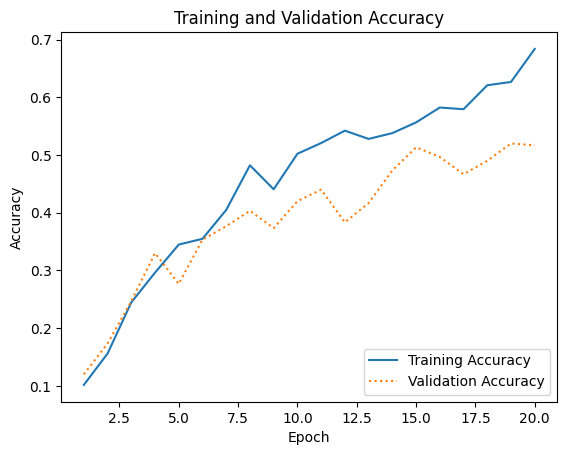

In [8]:
# Display results
plt.ion()  
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()
plt.show()